In [1]:
'''
https://medium.com/%E6%89%8B%E5%AF%AB%E7%AD%86%E8%A8%98/grad-cam-introduction-d0e48eb64adb
'''
import os
import cv2
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import skimage.transform
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from tensorflow.keras.models import load_model
model = load_model(r'C:\Users\user\Desktop\問號問號\fc_saliency_vgg16_ver0625.h5')
model.layers[-1].activation = None

In [3]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad
#計算梯度, 反向傳播

In [4]:
LAYER_NAME='block5_conv3'
gb_model = tf.keras.models.Model(
    inputs = [model.inputs],    
    outputs = [model.get_layer(LAYER_NAME).output])
gb_model.summary()
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
        layer.activation = guidedRelu
#將 Relu設為guideRelu
del model
# gb_model.save(r'C:\Users\user\Desktop\問號問號\forgrad.h5')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [6]:
def saliency_map(inputdata):
    fft = np.fft.fft2(inputdata)
    fshift = np.fft.fftshift(fft)
    LogAmp = np.log(np.abs(fshift))
    phase =np.angle(fshift)
    #SR
    BlurAmp = cv2.blur(LogAmp, (3,3))
    Spectral_res = LogAmp - BlurAmp
    #saliency map
    ishift = np.fft.ifftshift(np.exp(Spectral_res+1j*phase))
    Res_ifft = np.fft.ifft2(ishift)
    Res = np.abs(Res_ifft)
    #gaussian
    saliency_map = cv2.GaussianBlur(Res, (3,3),8)
    '''
    在Saliency Detection：A Spectral Residual Approach提到,
    用 gaussian fliter g(x)(sigma=8) 不確定是甚麼意思
    '''
    rge=np.max(saliency_map)-np.min(saliency_map)
    norm=(saliency_map-np.min(saliency_map))*255/rge
    return norm
def to_saliency(inputdata):
    saliency_r=saliency_map(inputdata[:,:,0])
    saliency_g=saliency_map(inputdata[:,:,1])
    saliency_b=saliency_map(inputdata[:,:,2])
    inputdata=np.stack((saliency_r,saliency_g,saliency_b), axis=-1)
    outputdata=cv2.normalize(inputdata.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    return outputdata.astype(np.float64)
def processing_image(img_path):
    # 讀取影像為 PIL 影像
    img = image.load_img(img_path, target_size=(224, 224))
    
    # 轉換 PIL 影像為 nparray
    x = image.img_to_array(img)
    
    x = to_saliency(x)
    # 加上一個 batch size，例如轉換 (224, 224, 3) 為 （1, 224, 224, 3) 
    x = np.expand_dims(x, axis=0)
    
    # 將 RBG 轉換為 BGR，並解減去各通道平均
    #x = preprocess_input(x)
    
    #x = tf.keras.applications.vgg19.preprocess_input(x)
    return x

In [7]:
def gudied_grad_cam(img, model):
    with tf.GradientTape() as tape:
        inputs = tf.cast(img, tf.float32)
        tape.watch(inputs)
        outputs = model(inputs)[0]
    grads = tape.gradient(outputs,inputs)[0]
    
    guided_back_prop =grads
    gb_viz = np.dstack((
                guided_back_prop[:, :, 0],
                guided_back_prop[:, :, 1],
                guided_back_prop[:, :, 2],
            ))       
    gb_viz -= np.min(gb_viz)
    gb_viz /= gb_viz.max() #gudied backpropagation
    
    weights = tf.reduce_mean(grads, axis=(0, 1))
    grad_cam = np.ones(outputs.shape[0: 2], dtype = np.float32)
    for i, w in enumerate(weights):
        grad_cam += w * outputs[:, :, i] #grads cam

    guided_cam = np.maximum(grad_cam, 0)
    guided_cam = guided_cam / np.max(guided_cam) # scale 0 to 1.0
    guided_cam = skimage.transform.resize(guided_cam, (224,224), preserve_range=True)
    #pointwise multiplcation of guided backprop and grad CAM 
    gd_gb = np.dstack((
            guided_back_prop[:, :, 0] * guided_cam, 
            guided_back_prop[:, :, 1] * guided_cam,
            guided_back_prop[:, :, 2] * guided_cam, #gudied grad cam
        ))
    return gb_viz, grad_cam, gd_gb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


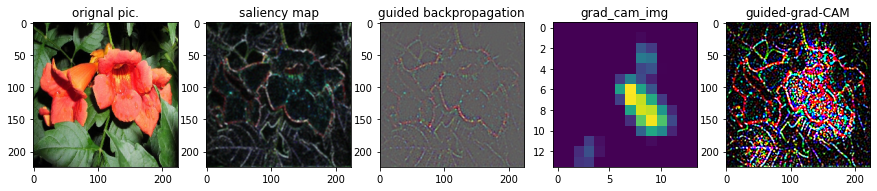

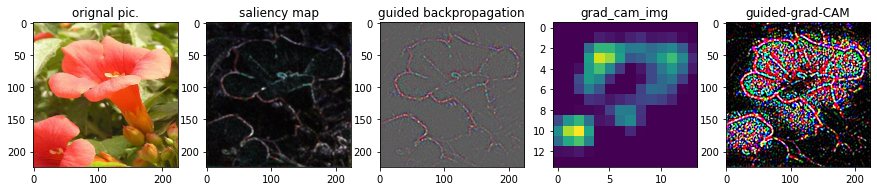

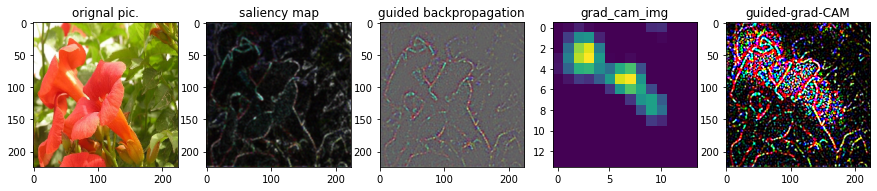

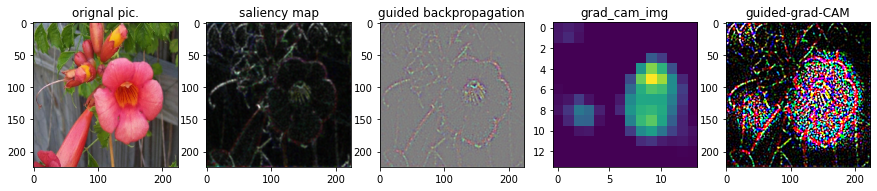

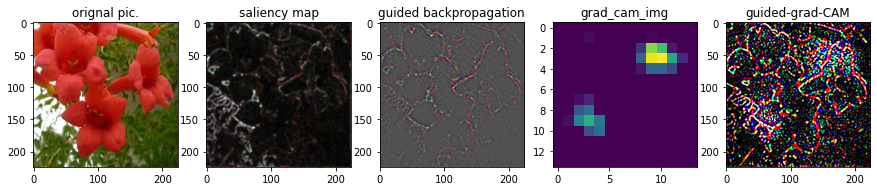

In [8]:
for root, dirs, files in os.walk(r'C:\Users\user\chou_paper_data\flower_data\valid\101',topdown=False):
    for name in files:
        img = processing_image(os.path.join(root,name))
        test = image.load_img(os.path.join(root,name), target_size=(224, 224))
        gb_viz, grad_cam, gd_gb=gudied_grad_cam(img,gb_model)
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(15,15), ncols=5)
        ax1.imshow(test)
        ax1.set_title(f'orignal pic.')
        ax2.imshow(img[0])
        ax2.set_title(f'saliency map')
        ax3.imshow(gb_viz)
        ax3.set_title(f'guided backpropagation')
        ax4.imshow(grad_cam)
        ax4.set_title(f'grad_cam_img')
        ax5.imshow(gd_gb)
        ax5.set_title(f'guided-grad-CAM')
del gb_viz, grad_cam, gd_gb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


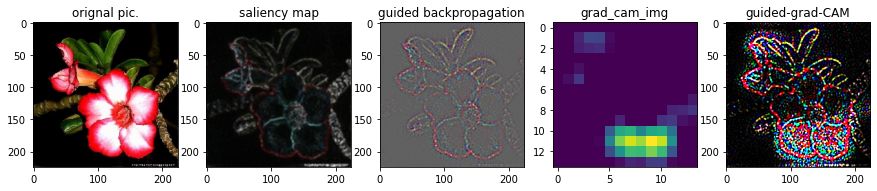

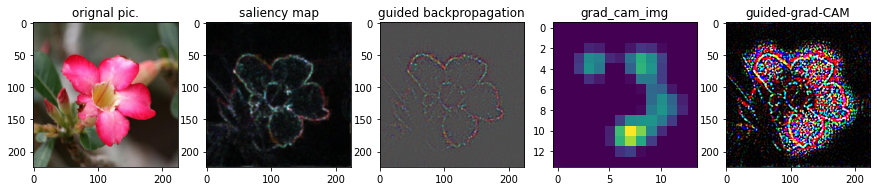

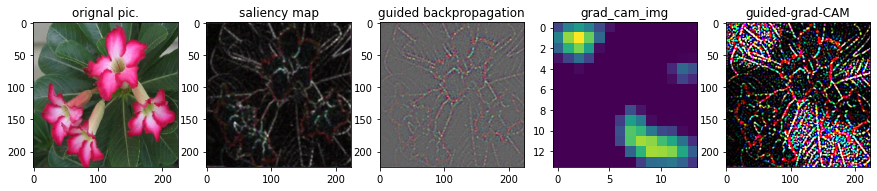

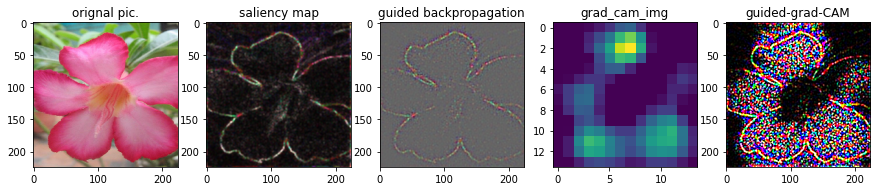

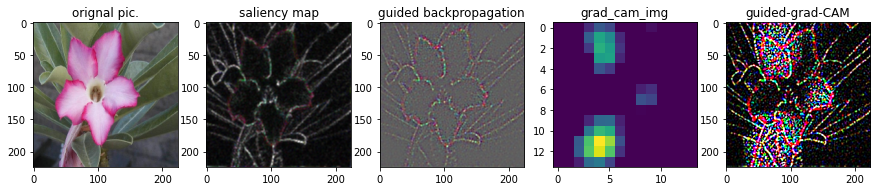

In [9]:
for root, dirs, files in os.walk(r'C:\Users\user\chou_paper_data\flower_data\valid\85',topdown=False):
    for name in files:
        img = processing_image(os.path.join(root,name))
        test = image.load_img(os.path.join(root,name), target_size=(224, 224))
        gb_viz, grad_cam, gd_gb=gudied_grad_cam(img,gb_model)
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(15,15), ncols=5)
        ax1.imshow(test)
        ax1.set_title(f'orignal pic.')
        ax2.imshow(img[0])
        ax2.set_title(f'saliency map')
        ax3.imshow(gb_viz)
        ax3.set_title(f'guided backpropagation')
        ax4.imshow(grad_cam)
        ax4.set_title(f'grad_cam_img')
        ax5.imshow(gd_gb)
        ax5.set_title(f'guided-grad-CAM')
del gb_viz, grad_cam, gd_gb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


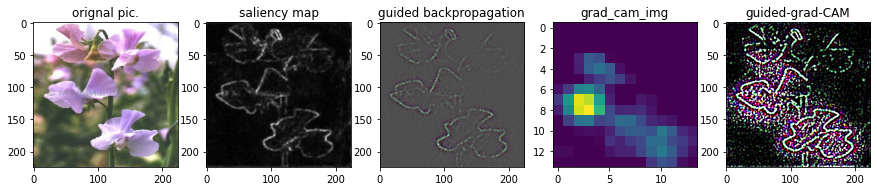

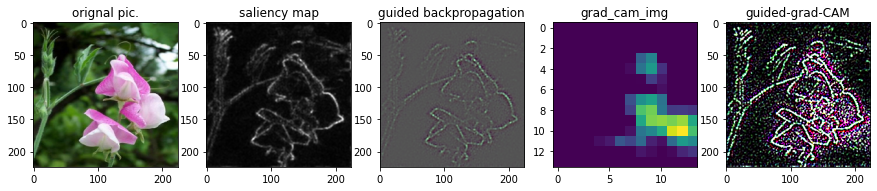

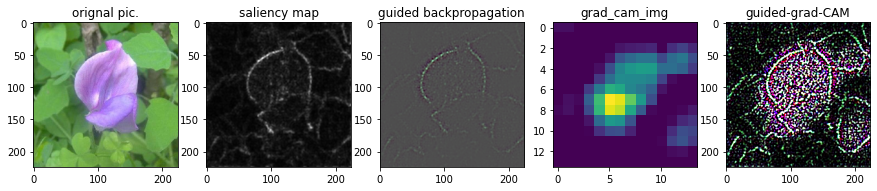

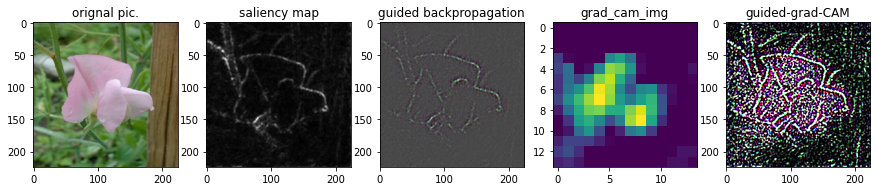

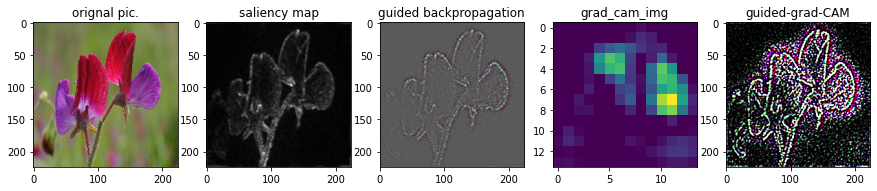

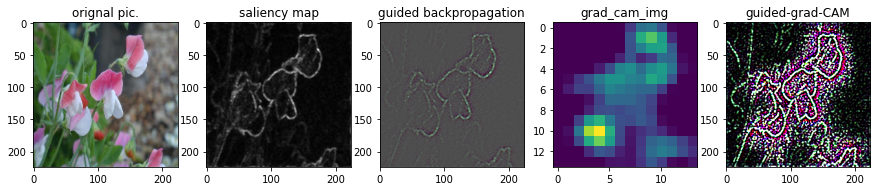

In [61]:
for root, dirs, files in os.walk(r'C:\Users\user\chou_paper_data\flower_data\valid\4',topdown=False):
    for name in files:
        img = processing_image(os.path.join(root,name))
        test = image.load_img(os.path.join(root,name), target_size=(224, 224))
        gb_viz, grad_cam, gd_gb=gudied_grad_cam(img,gb_model)
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(15,15), ncols=5)
        ax1.imshow(test)
        ax1.set_title(f'orignal pic.')
        ax2.imshow(img[0])
        ax2.set_title(f'saliency map')
        
        ax3.imshow(gb_viz)
        ax3.set_title(f'guided backpropagation')
        ax4.imshow(grad_cam)
        ax4.set_title(f'grad_cam_img')
        ax5.imshow(gd_gb)
        ax5.set_title(f'guided-grad-CAM')
del gb_viz, grad_cam, gd_gb